In [1]:
#Imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, auc, f1_score, recall_score, precision_score
from ipywidgets import interactive
from IPython.display import SVG,display
from graphviz import Source
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cancer-data-brazil/municipio.csv
/kaggle/input/cancer-data-brazil/cancer_data_eng.csv


In [2]:
#Importando o dataframe
df = pd.read_csv('../input/cancer-data-brazil/cancer_data_eng.csv', encoding='ISO-8859-1')
pd.set_option('display.max_columns', None)
df.columns=df.columns.str.replace('.','')

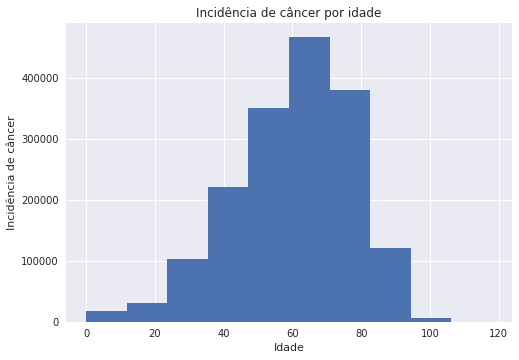

In [3]:
#Fazendo uma análise exploratória da incidência de câncer por idade

#Removendo idades acima de 122 anos
dfage = df[ (df['Age'] > 122)].index
df.drop(dfage , inplace=True)

#Plotando o histograma de incidência de câncer por idade
ax = df.hist(column='Age')
ax = plt.title('Incidência de câncer por idade')
ax = plt.xlabel('Idade')
ax = plt.ylabel('Incidência de câncer')

In [4]:
#Fazendo uma análise exploratória de morfologias de câncer mais comum por gênero

#Separando o dataframe pelo gênero masculino, agrupando por gênero e morfologia do câncer, contando a frequência das morfologias de câncer
df_m = df.query('Gender=="MASCULINO"')
dfgroupm = df_m.groupby(["Gender", "MorphologyDescription"]).size().reset_index(name="Frequência")

#Exibindo os valores de frequências obtidos em ordem decrescente
print("As 5 morfologias de câncer mais comuns em pessoas do sexo masculino são:")
print(dfgroupm.sort_values(by='Frequência', ascending=False).iloc[:5:])


As 5 morfologias de câncer mais comuns em pessoas do sexo masculino são:
        Gender          MorphologyDescription  Frequência
54   MASCULINO            ADENOCARCINOMA, SOE      186626
537  MASCULINO              NEOPLASIA MALIGNA       80755
165  MASCULINO   CARCINOMA ESCAMOCELULAR, SOE       76243
94   MASCULINO     CARCINOMA BASOCELULAR, SOE       73719
114  MASCULINO  CARCINOMA DE CELULAS ACINOSAS       41472


In [5]:
#Fazendo uma análise exploratória de morfologias de câncer mais comum por gênero

#Separando o dataframe pelo gênero feminino, agrupando por gênero e morfologia do câncer, contando a frequência das morfologias de câncer
df_f = df.query('Gender=="FEMININO"')
dfgroupf = df_f.groupby(["Gender", "MorphologyDescription"]).size().reset_index(name="Frequência")

#Exibindo os valores de frequências obtidos em ordem decrescente
print("As 5 morfologias de câncer mais comuns em pessoas do sexo feminino são:")
print(dfgroupf.sort_values(by='Frequência', ascending=False).iloc[:5,:])


As 5 morfologias de câncer mais comuns em pessoas do sexo feminino são:
       Gender         MorphologyDescription  Frequência
161  FEMININO  CARCINOMA DUCTAL INFILTRANTE      144974
59   FEMININO           ADENOCARCINOMA, SOE       91659
575  FEMININO             NEOPLASIA MALIGNA       88062
102  FEMININO    CARCINOMA BASOCELULAR, SOE       82251
176  FEMININO  CARCINOMA ESCAMOCELULAR, SOE       68175


In [6]:
#Fazendo uma análise exploratória de morfologias de câncer mais comum por gênero

#Separando o dataframe pelo gênero ignorado ou não informado, agrupando por gênero e morfologia do câncer, contando a frequência das morfologias de câncer
df_i = df.query('Gender=="IGNORADO"')
dfgroupi = df_i.groupby(["Gender", "MorphologyDescription"]).size().reset_index(name="Frequência")

#Exibindo os valores de frequências obtidos em ordem decrescente
print("As 5 morfologias de câncer mais comuns em pessoas de sexo ignorado ou não informado são:")
print(dfgroupi.sort_values(by='Frequência', ascending=False).iloc[:5,:])



As 5 morfologias de câncer mais comuns em pessoas de sexo ignorado ou não informado são:
      Gender          MorphologyDescription  Frequência
5   IGNORADO     CARCINOMA BASOCELULAR, SOE          56
12  IGNORADO   CARCINOMA ESCAMOCELULAR, SOE          33
1   IGNORADO            ADENOCARCINOMA, SOE          20
4   IGNORADO  CARCINOMA BASOCELULAR NODULAR          17
28  IGNORADO              NEOPLASIA MALIGNA           7


As 5 morfologias de câncer mais letais são:
    TypeofDeath         MorphologyDescription  Frequência
530      CÂNCER             NEOPLASIA MALIGNA      107113
51       CÂNCER           ADENOCARCINOMA, SOE       61973
532      CÂNCER             NEOPLASMA MALIGNO       35169
159      CÂNCER  CARCINOMA ESCAMOCELULAR, SOE       30058
144      CÂNCER  CARCINOMA DUCTAL INFILTRANTE       17965


([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

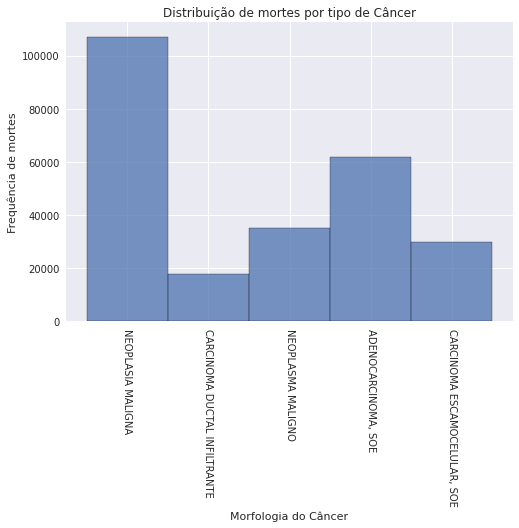

In [7]:
#Fazendo uma análise exploratória de morfologias de câncer mais letais

#Separando o DataFrame por câncer como causa de morte
dfmc = df.query('TypeofDeath =="CÂNCER"')
#Agrupando o DataFrame por causa da morte e morfologia do câncer, contando a frequência
dfgroup = dfmc.groupby(["TypeofDeath", "MorphologyDescription"]).size().reset_index(name="Frequência")
#Exibindo as 5 morfologias de câncer mais letais em ordem decrescente
print("As 5 morfologias de câncer mais letais são:")
dfcletais = dfgroup.sort_values(by='Frequência', ascending=False).iloc[:5,:]
print(dfcletais) 

#Separando o DataFrame por câncer como causa de morte e pelas 5 morfologias mais letais
df1 = df.query('TypeofDeath == "CÂNCER"')
df2 = df1.query('MorphologyDescription == "NEOPLASIA MALIGNA" | MorphologyDescription == "ADENOCARCINOMA, SOE" | MorphologyDescription == "NEOPLASMA MALIGNO" | MorphologyDescription == "CARCINOMA ESCAMOCELULAR, SOE" | MorphologyDescription == "CARCINOMA DUCTAL INFILTRANTE"')

#Plotando o histograma de Distribuição de mortes por tipo de Câncer
ax = sns.histplot(data=df2, x="MorphologyDescription")
ax = plt.title("Distribuição de mortes por tipo de Câncer")
ax = plt.ylabel("Frequência de mortes")
ax = plt.xlabel("Morfologia do Câncer")
plt.xticks(rotation=270)

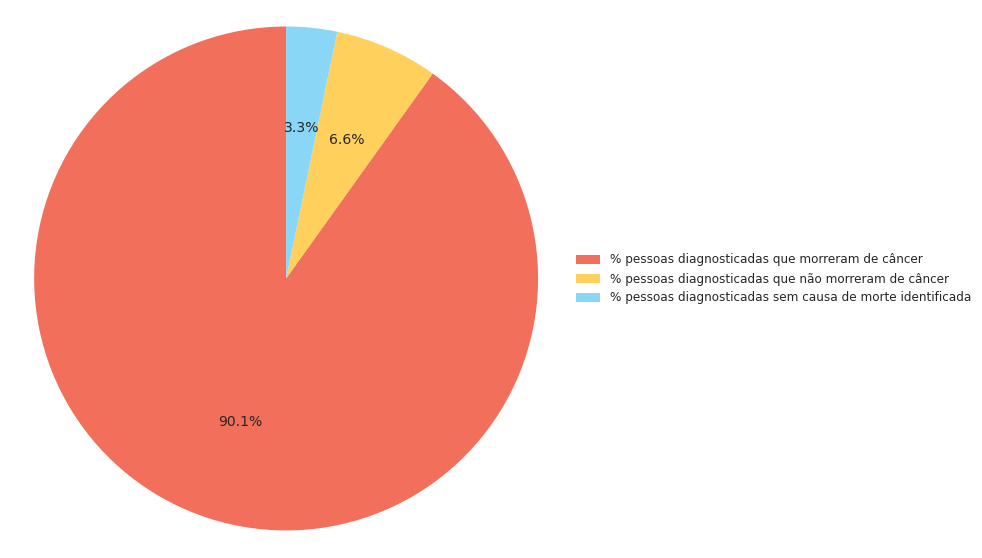

In [8]:
#Fazendo uma análise exploratória das causas de morte de pessoas diagnosticadas com câncer

#Separando um DataFrame para pessoas que já morreram
df_sv = df.query('StatusVital=="MORTO"')

#Separando três DataFrames por causa de morte
dfmc = df_sv.query('TypeofDeath =="CÂNCER"')
dfmnc = df_sv.query('TypeofDeath =="NÃO CÂNCER"')
dfnan = df_sv.query('TypeofDeath != "CÂNCER" & TypeofDeath !="NÃO CÂNCER"')

#Calculando a porcentagem de pessoas que morreraram de câncer, de outra causa ou não tiveram a causa da morte identificada
mc = dfmc[dfmc.columns[0]].count() / df_sv[df_sv.columns[0]].count()
mnc = dfmnc[dfmnc.columns[0]].count() / df_sv[df_sv.columns[0]].count()
mnan = dfnan[dfnan.columns[0]].count() / df_sv[df_sv.columns[0]].count()

#Plotando o gráfico de porcentagem de causas de morte
labels = '% pessoas diagnosticadas que morreram de câncer', '% pessoas diagnosticadas que não morreram de câncer', '% pessoas diagnosticadas sem causa de morte identificada'
sizes = [mc, mnc, mnan]
explode = (0, 0, 0)
fig1, ax1 = plt.subplots(figsize=(10,10))
cores = ['#f2705b','#ffd05c','#89d6f7']
ax1.pie(sizes, explode=explode, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=cores,textprops={'fontsize': 14})
ax1.legend(labels,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize='large')
ax1.axis('equal')
plt.show()

Text(0, 0.5, 'Frequências')

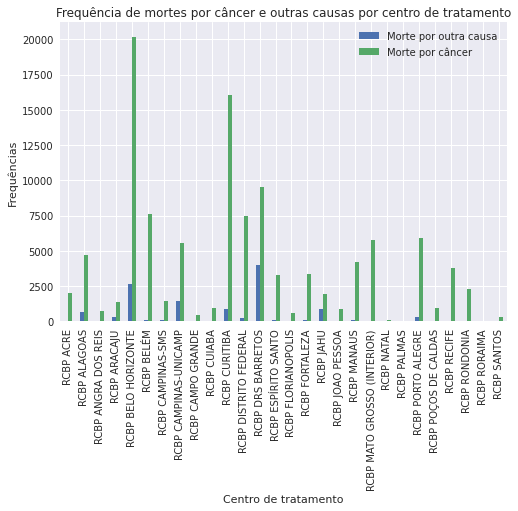

In [9]:
#Fazendo uma análise exploratória da frequência de mortes por câncer e por outras causas por centro de tratamento

#Separando um DataFrame para pessoas que já morreram
df_morto = df.query('StatusVital=="MORTO"')
df_morto["TypeofDeath"].fillna('NÃO CÂNCER', inplace = True) 

#Substituindo os valores não numéricos por valores numéricos
mapping = {"NÃO CÂNCER": 0, "CÂNCER": 1}
df_morto.replace({"TypeofDeath":mapping}, inplace=True)

#Plotando o gráfico de causas de mortes por centro de tratamento
pd.crosstab(df_morto.RCBPName,df_morto.TypeofDeath).plot(kind='bar')
plt.title('Frequência de mortes por câncer e outras causas por centro de tratamento')
plt.legend(['Morte por outra causa', 'Morte por câncer'])
plt.xlabel('Centro de tratamento')
plt.ylabel('Frequências')

In [10]:
#Fazendo uma análise exploratória da taxa de morte por câncer por centro de tratamento

#Agrupando o DataFrame por centro de tratamento e causa da morte, contando a frequência
dfgroupbytypeofdeath = df_morto.groupby(["RCBPName", "TypeofDeath"]).size().reset_index(name="Frequência")

#Inserindo a coluna Taxa com valor padrão 0
dfgroupbytypeofdeath.insert(3, "Taxa", "0")

#Inserindo valores na coluna Taxa com base na porcentagem da divisão da frequência de mortes por câncer pela soma da frequência de mortes por câncer e por outras causas
for i in range(0, len(dfgroupbytypeofdeath), 2):
    taxa = 100*(dfgroupbytypeofdeath.iloc[i+1]['Frequência']/(dfgroupbytypeofdeath.iloc[i+1]['Frequência'] + dfgroupbytypeofdeath.iloc[i]['Frequência']))
    dfgroupbytypeofdeath.at[i, 'Taxa'] = taxa

#Removendo valores que não foram preenchidos e a causa da morte
dfgroupbytypeofdeath = dfgroupbytypeofdeath.drop(['Frequência'], axis=1)
dfgroupbytypeofdeath = dfgroupbytypeofdeath.drop(['TypeofDeath'], axis=1)
dfgroupbytypeofdeath = dfgroupbytypeofdeath.query('Taxa!="0"')

#Exibindo o DataFrame com a taxa de morte por câncer por centro de tratamento
print("Taxa de morte por câncer por centro de tratamento:")
dfgroupbytypeofdeath

Taxa de morte por câncer por centro de tratamento:


,RCBPName,Taxa
0,RCBP ACRE,97.399411
2,RCBP ALAGOAS,87.220566
4,RCBP ANGRA DOS REIS,94.492044
6,RCBP ARACAJU,80.762359
8,RCBP BELO HORIZONTE,88.375044
10,RCBP BELÉM,99.053546
12,RCBP CAMPINAS-SMS,93.416722
14,RCBP CAMPINAS-UNICAMP,79.576356
16,RCBP CAMPO GRANDE,98.423423
18,RCBP CUIABA,98.483316


In [13]:
#Separando o dataframe pelas colunas desejadas e fazendo as manipulações necessárias
dftest = df.query('Gender!="IGNORADO"')
dftest = dftest.loc[:,['Gender','Age','TypeofDeath']]
df[['TypeofDeath']] = df[['TypeofDeath']].fillna(value=1)
dftest.dropna(subset=['Age'], inplace = True)

#Substituindo os valores não numéricos por valores numéricos
mapping = {"FEMININO": 0, "MASCULINO": 1}
dftest.replace({"Gender":mapping}, inplace=True)

mapping = {"NÃO CÂNCER": 0, "CÂNCER": 1}
dftest.replace({"TypeofDeath":mapping}, inplace=True)

In [14]:
#Preparando a separação em treino e teste
X, y = dftest[['Gender', 'Age']], dftest[['TypeofDeath']]

#Aplicando um oversample devido ao fato dos dados estarem desbalanceados
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

#Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,random_state = 1,test_size=0.30,stratify=y_resampled)

In [15]:
#Verificando o score do modelo pelo método de Hold-out
tree = DecisionTreeClassifier (max_depth = 2, random_state = 0)
tree.fit(X_train, y_train)
model = tree.fit(X_train, y_train)
score = tree.score(X_test, y_test)
print("Score:",score)
#Pode-se observar que o score alcançado pelo modelo, não se faz satisfatório mesmo após o oversample dos dados

Score: 0.6547025133479626


In [18]:
#Definindo o estimador e ajustando aos dados
estimator = DecisionTreeClassifier(
           random_state = 0
          ,criterion = "gini"
          ,splitter = "best"
          ,max_depth = 1
    )
estimator.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1, random_state=0)

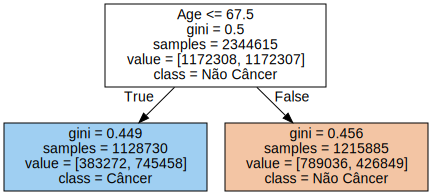

In [21]:
#Plotando a árvore de decisão
graph = Source(export_graphviz(estimator
      , out_file=None
      , feature_names=['Gender', 'Age']
      , class_names=['Não Câncer', 'Câncer']
      , impurity=True
      , filled = True))
display(SVG(graph.pipe(format='svg')))

#Podemos observar que o DataFrame não é bem estruturado para realização de um modelo de predição, 
#uma vez que tem uma pobreza de dados quantitativos e um grande desbalanceamento nos dados